William Alan Cahyadi

2602110752

3a. Arsitektur Generative Adversarial Network (GAN) yang ditunjukkan dalam gambar terdiri dari dua komponen utama yaitu generator dan discriminator

Cara Kerja Arsitektur GAN
1.	Generator:
Generator menerima input berupa random noise yang biasanya berupa vektor dengan distribusi normal atau uniform. Lalu generator mengubah noise vector ini menjadi gambar yang menyerupai data asli. Proses ini dilakukan melalui serangkaian lapisan neural network yang bertujuan untuk menghasilkan gambar realistis dari ramndom noise. Kemudian hasil dari generator adalah fake image yang menyerupai gambar dari dataset asli (training set)
2.	Discriminator:
Discriminator menerima dua jenis input gambar yaitu real images dari dataset asli dan fake images yang dihasilkan oleh generator. Discriminator adalah jaringan neural yang bertugas membedakan antara real image dan fake image. Discriminator mengeluarkan probabilitas, yang menunjukkan seberapa besar kemungkinan gambar yang diberikan adalah real image. Kemudian discriminator memberikan output berupa nilai probabilitas yang menunjukkan apakah gambar tersebut nyata (real) atau palsu (fake)

Training Set GAN
Generator berusaha menghasilkan gambar yang sangat mirip dengan real image agar dapat menipu discriminator. Tujuannya adalah meminimalkan kemungkinan fake image dikenali sebagai palsu oleh discriminator
Discriminator berusaha menjadi lebih baik dalam membedakan antara real image dan fake images. Tujuannya adalah memaksimalkan kemungkinan real image dikenali sebagai nyata dan fake imagge dikenali sebagai palsu

Langkah-langkah:
-	Generator dan discriminator diinisialisasi dengan random noise

-	Discriminator dilatih menggunakan real image dari dataset dan fake image yang dihasilkan oleh generator. Kemudian discriminator memperbarui bobotnya untuk meningkatkan akurasi dalam membedakan real image dan palsu

-	Generator dilatih menggunakan output dari discriminator dan generator meningkatkan kemampuannya menghasilkan gambar yang dapat menipu discriminator

-	Langkah-langkah di atas diulangi sebanyak n epoch sampai model mencapai model yang konvergen, yaitu ketika generator menghasilkan gambar yang sangat mirip dengan real image, dan discriminator tidak dapat lagi membedakan dengan baik antara real image dan fake image



In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2DTranspose, BatchNormalization, LeakyReLU, ReLU, Reshape, Dense, Input, Embedding, multiply, Flatten, Dropout, Conv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import os
import gzip

In [31]:
def load_mnist(path, kind='train'):
    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte.gz')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte.gz')

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 28, 28)

    return images, labels

path = '.'
train_images, train_labels = load_mnist(path, kind='train')
test_images, test_labels = load_mnist(path, kind='t10k')

Generative Adversarial Network (GAN) untuk menghasilkan gambar kategori "T-shirt/top" dan "Trouser" dari dataset Fashion MNIST

In [32]:
train_filter = (train_labels == 0) | (train_labels == 1)
test_filter = (test_labels == 0) | (test_labels == 1)

X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_test = (X_test.astype(np.float32) - 127.5) / 127.5

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

GAN Architecture

Input ini digabungkan dan melalui beberapa dense layer dan Conv2DTranspose untuk menghasilkan gambar yang menyerupai data asli, dengan lapisan BatchNormalization dan LeakyReLU

In [33]:
def build_generator():
    noise = Input(shape=(100,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(2, 100)(label))
    model_input = multiply([noise, label_embedding])

    model = Sequential()

    model.add(Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 256)))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(1, kernel_size=4, strides=1, padding='same', use_bias=False, activation='tanh'))

    img = model(model_input)
    return Model([noise, label], img)

Discriminator bertugas membedakan antara gambar asli dan gambar yang dihasilkan oleh Generator.

In [34]:
def build_discriminator():
    img = Input(shape=(28, 28, 1))
    label = Input(shape=(1,), dtype='int32')

    label_embedding = Flatten()(Embedding(2, 28 * 28)(label))
    label_embedding = Reshape((28, 28, 1))(label_embedding)
    concatenated = tf.keras.layers.Concatenate()([img, label_embedding])

    model = Sequential()
    model.add(Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=(28, 28, 2)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))
    validity = model(concatenated)

    return Model([img, label], validity)

kemudian diproses melalui beberapa layer Conv2D dan LeakyReLU, dengan dropout untuk mencegah overfitting.

Generator akan menghasilkan gambar yang semakin realistis, sementara Discriminator dilatih untuk membedakan gambar real or fake

In [35]:
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

Untuk memastikan training yang stable, digunakan Wasserstein loss with gradient penalty

Compile Model

In [37]:
generator = build_generator()
discriminator = build_discriminator()

generator_optimizer = Adam(0.0002, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = Adam(0.0002, beta_1=0.5, beta_2=0.9)

GAN Training

In [38]:
epochs = 500
batch_size = 64
sample_interval = 100
gradient_penalty_weight = 10.0

valid = -np.ones((batch_size, 1))
fake = np.ones((batch_size, 1))

2/2 [==============================] - 0s 105ms/step
0 [D loss: 7.527348041534424] [G loss: -0.012617606669664383]
1/1 [==============================] - 0s 219ms/step


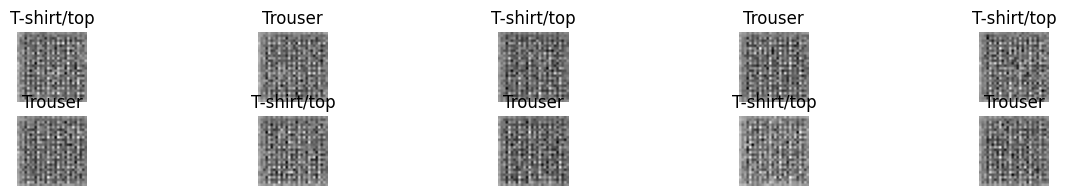

2/2 [==============================] - 0s 110ms/step
100 [D loss: -12.665013313293457] [G loss: -23.780357360839844]
1/1 [==============================] - 0s 57ms/step


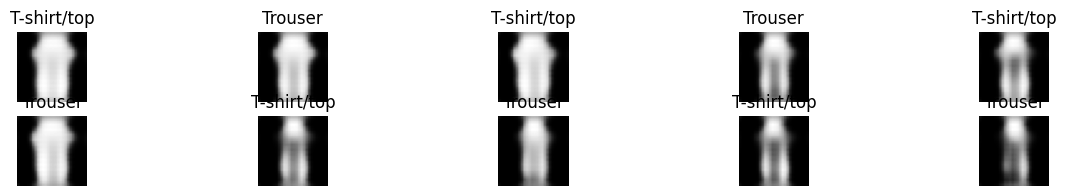

2/2 [==============================] - 0s 178ms/step
200 [D loss: -9.911709785461426] [G loss: -12.973284721374512]
1/1 [==============================] - 0s 57ms/step


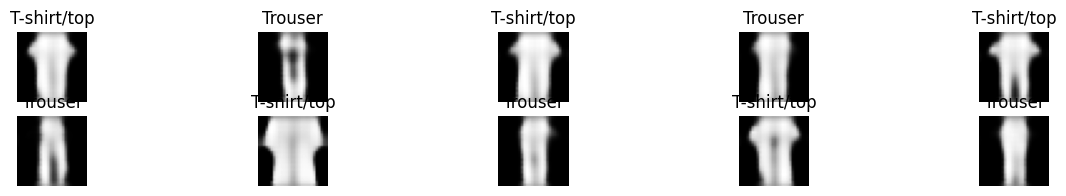

2/2 [==============================] - 0s 188ms/step
300 [D loss: -5.678742408752441] [G loss: -13.986854553222656]
1/1 [==============================] - 0s 59ms/step


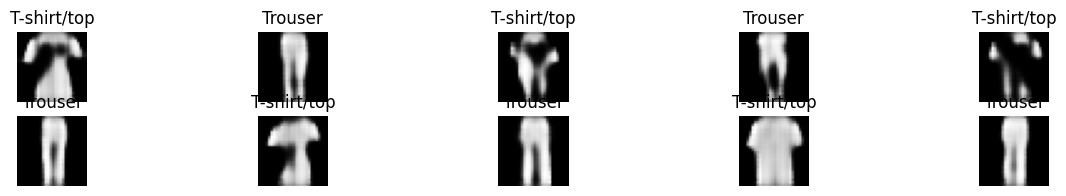

2/2 [==============================] - 0s 180ms/step
400 [D loss: -5.221324443817139] [G loss: -15.91507339477539]
1/1 [==============================] - 0s 53ms/step


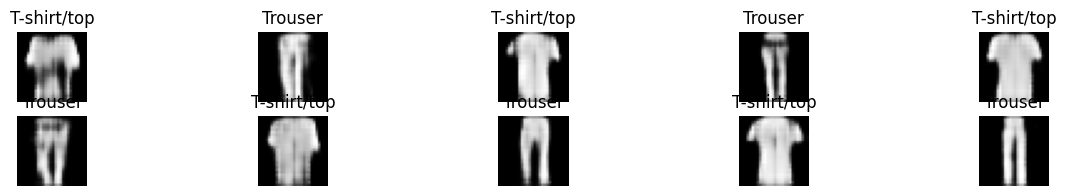

2/2 [==============================] - 0s 132ms/step


In [39]:
def gradient_penalty(real_images, fake_images, real_labels):
    alpha = tf.random.uniform(shape=[real_images.shape[0], 1, 1, 1], minval=0., maxval=1.)
    interpolated = real_images + alpha * (fake_images - real_images)
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        validity_interpolated = discriminator([interpolated, real_labels])
    gradients = gp_tape.gradient(validity_interpolated, [interpolated])[0]
    gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
    gp = tf.reduce_mean((gradients_norm - 1.0) ** 2)
    return gp


for epoch in range(epochs):
    for _ in range(5):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_labels = np.random.randint(0, 2, (batch_size, 1))
        gen_imgs = generator.predict([noise, gen_labels])

        with tf.GradientTape() as disc_tape:
            real_validity = discriminator([imgs, labels])
            fake_validity = discriminator([gen_imgs, gen_labels])
            gp = gradient_penalty(imgs, gen_imgs, labels)
            d_loss = tf.reduce_mean(fake_validity) - tf.reduce_mean(real_validity) + gradient_penalty_weight * gp
        gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    noise = np.random.normal(0, 1, (batch_size, 100))
    valid_labels = np.random.randint(0, 2, (batch_size, 1))

    with tf.GradientTape() as gen_tape:
        gen_imgs = generator([noise, valid_labels])
        fake_validity = discriminator([gen_imgs, valid_labels])
        g_loss = -tf.reduce_mean(fake_validity)
    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))


    if epoch % sample_interval == 0:
        print(f"{epoch} [D loss: {d_loss.numpy()}] [G loss: {g_loss.numpy()}]")
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.tile(np.array([0, 1]), r * c // 2).reshape(-1, 1)
        gen_imgs = generator.predict([noise, sampled_labels])
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c, figsize=(15, 2))
        cnt = 0

        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].set_title(f"{'T-shirt/top' if sampled_labels[cnt] == 0 else 'Trouser'}")
                axs[i, j].axis('off')
                cnt += 1
        plt.show()

Fréchet Inception Distance (FID) Evaluation

FID membandingkan feature distribution dari gambar asli dan gambar yang dihasilkan, semakin rendah semakin bagus

In [40]:
!pip install tensorflow-gan

In [42]:
from scipy.linalg import sqrtm

def calculate_fid_score(real_images, generated_images):
    mu1, sigma1 = np.mean(real_images, axis=0), np.cov(real_images, rowvar=False)
    mu2, sigma2 = np.mean(generated_images, axis=0), np.cov(generated_images, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def generate_and_calculate_fid(generator, X_train, y_train, num_samples=1000):
    noise = np.random.normal(0, 1, (num_samples, 100))
    sampled_labels = np.random.randint(0, 2, (num_samples, 1))
    gen_imgs = generator.predict([noise, sampled_labels])

    gen_imgs = gen_imgs.reshape(num_samples, -1)

    real_imgs = []
    for label in sampled_labels:
        idx = np.where(y_train == label)[0]
        real_img = X_train[np.random.choice(idx)]
        real_imgs.append(real_img)
    real_imgs = np.array(real_imgs)

    real_imgs = real_imgs.reshape(num_samples, -1)

    fid = calculate_fid_score(real_imgs, gen_imgs)
    return fid

fid = generate_and_calculate_fid(generator, X_train, y_train)
print(f"FID: {fid}")

32/32 [==============================] - 3s 104ms/step
FID: 33.614075630903244


FID score yang diperoleh menunjukkan bahwa gambar yang dihasilkan oleh model cukup realistis dan mendekati distribusi data asli. FID membandingkan feature distribution dari gambar asli dan gambar yang dihasilkan, semakin rendah semakin bagus. Sehingga FID yang didapatkan ini sudah baik.